# HW06 — Деревья решений и ансамбли

Цель работы - провести честный ML-эксперимент и сравнить:
- бейзлайны;
- одиночное дерево решений;
- ансамбли (Random Forest, Boosting).

Для сравнения используется фиксированный train/test-сплит
и единый набор метрик качества.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve
)

from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import json
import joblib


In [2]:
df = pd.read_csv("S06-hw-dataset-02.csv")

In [3]:
df.head()


,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
0,1,-0.149235,-2.826966,-0.522901,-4.198449,1.364943,0.815043,-1.195518,-1.932232,2.396353,...,-0.159323,0.448015,0.572745,0.149916,0.878392,-0.679733,1.412751,0.421883,9.217167,1
1,2,-1.966180,-4.877542,0.268367,-9.607791,0.097149,1.347185,-3.872575,-0.395117,1.710068,...,-0.389212,1.383794,0.169876,0.043969,-0.963545,1.006643,-2.488690,9.590124,24.772826,0
2,3,-0.555964,-0.999920,0.209673,-14.119498,-1.808950,-0.006222,-4.651108,0.911944,-0.289037,...,-1.383970,3.044321,-0.182864,1.425649,-8.418598,-4.629754,-0.439798,0.555919,41.800517,0
3,4,-2.049199,-5.600713,-1.664677,-6.263893,-5.224455,0.848351,1.407210,-0.542080,0.119102,...,-2.713080,2.762637,-0.520796,-0.142455,1.668338,2.292810,-10.744916,11.476977,65.315860,0
4,5,-0.220556,4.889479,-2.235840,6.450046,0.774389,-2.382625,2.584816,4.211856,-0.317889,...,-1.302872,2.478862,1.528610,1.098131,3.547087,2.517757,-9.364106,-1.078404,93.017870,0


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 39 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       18000 non-null  int64  
 1   f01      18000 non-null  float64
 2   f02      18000 non-null  float64
 3   f03      18000 non-null  float64
 4   f04      18000 non-null  float64
 5   f05      18000 non-null  float64
 6   f06      18000 non-null  float64
 7   f07      18000 non-null  float64
 8   f08      18000 non-null  float64
 9   f09      18000 non-null  float64
 10  f10      18000 non-null  float64
 11  f11      18000 non-null  float64
 12  f12      18000 non-null  float64
 13  f13      18000 non-null  float64
 14  f14      18000 non-null  float64
 15  f15      18000 non-null  float64
 16  f16      18000 non-null  float64
 17  f17      18000 non-null  float64
 18  f18      18000 non-null  float64
 19  f19      18000 non-null  float64
 20  f20      18000 non-null  float64
 21  f21      180

In [5]:
df.describe()


,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,...,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,1.800000e+04,18000.000000
mean,9000.500000,-0.418555,0.614251,0.004559,0.059000,0.405086,0.012123,-0.283473,-0.266880,0.255107,...,-0.139825,0.108568,0.007238,0.000904,-0.716862,-0.274520,0.344991,1.517339,2.576221e+01,0.262611
std,5196.296758,2.178005,3.926778,1.000134,5.713672,2.497581,0.987226,2.193891,2.081431,2.225776,...,2.148834,2.234315,0.997861,1.002115,3.913704,2.482890,4.927315,10.630850,5.423748e+01,0.440065
min,1.000000,-10.014698,-15.510323,-4.031762,-23.663256,-12.289308,-3.741536,-9.591425,-8.293319,-13.655742,...,-8.171469,-9.214171,-3.937091,-3.963063,-19.389908,-10.031559,-20.768452,-107.788145,1.895059e-07,0.000000
25%,4500.750000,-1.866134,-2.048192,-0.673127,-3.544964,-1.153000,-0.653090,-1.743214,-1.688121,-1.177480,...,-1.589638,-1.369266,-0.663023,-0.684164,-3.286842,-1.897893,-2.752685,-2.018750,1.226029e+00,0.000000
50%,9000.500000,-0.465100,0.600291,0.003581,0.072826,0.485625,0.018765,-0.251263,-0.302463,0.350739,...,-0.204785,0.158715,0.001912,-0.003157,-0.618472,-0.339901,0.573153,0.318011,6.581865e+00,0.000000
75%,13500.250000,0.966393,3.229850,0.671390,3.689490,2.075739,0.689304,1.195481,1.109589,1.764113,...,1.254595,1.600671,0.677296,0.676558,1.948803,1.314163,3.649794,4.212111,2.576847e+01,1.000000
max,18000.000000,9.589975,15.417329,3.817025,26.815691,10.665184,3.528280,7.794627,8.892834,8.699629,...,9.290667,8.794320,4.341030,3.781380,14.065595,10.639974,20.226291,94.891804,1.103449e+03,1.000000


In [6]:
df["target"].value_counts(normalize=True)


target
0    0.737389
1    0.262611
Name: proportion, dtype: float64

Датасет содержит N наблюдений и числовые признаки.
Целевой признак `target` бинарный.

Баланс классов умеренный, что позволяет использовать
accuracy и ROC-AUC как основные метрики.


In [7]:
X = df.drop(columns=["target", "id"], errors="ignore")
y = df["target"]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


Фиксированный random_state обеспечивает воспроизводимость эксперимента,
а стратификация сохраняет баланс классов в train и test.


In [9]:
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]

dummy_metrics = {
    "accuracy": accuracy_score(y_test, y_pred_dummy),
    "f1": f1_score(y_test, y_pred_dummy),
    "roc_auc": roc_auc_score(y_test, y_proba_dummy),
}
dummy_metrics


{'accuracy': 0.7375, 'f1': 0.0, 'roc_auc': 0.5}

In [10]:
logreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000))
])

logreg_pipe.fit(X_train, y_train)

y_pred_lr = logreg_pipe.predict(X_test)
y_proba_lr = logreg_pipe.predict_proba(X_test)[:, 1]

logreg_metrics = {
    "accuracy": accuracy_score(y_test, y_pred_lr),
    "f1": f1_score(y_test, y_pred_lr),
    "roc_auc": roc_auc_score(y_test, y_proba_lr),
}
logreg_metrics


{'accuracy': 0.8119444444444445,
 'f1': 0.5606748864373783,
 'roc_auc': 0.7976914875596609}

In [11]:
dt = DecisionTreeClassifier(random_state=42)

param_grid_dt = {
    "max_depth": [3, 5, 10],
    "min_samples_leaf": [1, 5, 10],
}

dt_search = GridSearchCV(
    dt,
    param_grid_dt,
    scoring="roc_auc",
    cv=5
)

dt_search.fit(X_train, y_train)
dt_best = dt_search.best_estimator_


In [12]:
y_proba_dt = dt_best.predict_proba(X_test)[:, 1]
dt_metrics = {
    "accuracy": accuracy_score(y_test, dt_best.predict(X_test)),
    "f1": f1_score(y_test, dt_best.predict(X_test)),
    "roc_auc": roc_auc_score(y_test, y_proba_dt),
}
dt_metrics


{'accuracy': 0.8383333333333334,
 'f1': 0.6576470588235294,
 'roc_auc': 0.8371031995137457}

In [13]:
rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    "n_estimators": [100],
    "max_depth": [None, 10],
    "min_samples_leaf": [1, 5],
}

rf_search = GridSearchCV(
    rf,
    param_grid_rf,
    scoring="roc_auc",
    cv=5
)

rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_


In [14]:
y_proba_rf = rf_best.predict_proba(X_test)[:, 1]
rf_metrics = {
    "accuracy": accuracy_score(y_test, rf_best.predict(X_test)),
    "f1": f1_score(y_test, rf_best.predict(X_test)),
    "roc_auc": roc_auc_score(y_test, y_proba_rf),
}
rf_metrics


{'accuracy': 0.8905555555555555,
 'f1': 0.7555831265508685,
 'roc_auc': 0.9261519146264909}

In [15]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

y_proba_gb = gb.predict_proba(X_test)[:, 1]
gb_metrics = {
    "accuracy": accuracy_score(y_test, gb.predict(X_test)),
    "f1": f1_score(y_test, gb.predict(X_test)),
    "roc_auc": roc_auc_score(y_test, y_proba_gb),
}
gb_metrics


{'accuracy': 0.8688888888888889,
 'f1': 0.7075588599752168,
 'roc_auc': 0.8961635727737424}

In [16]:
metrics_df = pd.DataFrame.from_dict({
    "Dummy": dummy_metrics,
    "LogReg": logreg_metrics,
    "DecisionTree": dt_metrics,
    "RandomForest": rf_metrics,
    "GradientBoosting": gb_metrics,
}, orient="index")

metrics_df


,accuracy,f1,roc_auc
Dummy,0.737500,0.000000,0.500000
LogReg,0.811944,0.560675,0.797691
DecisionTree,0.838333,0.657647,0.837103
RandomForest,0.890556,0.755583,0.926152
GradientBoosting,0.868889,0.707559,0.896164


In [17]:
metrics_df.to_json("artifacts/metrics_test.json", indent=2)


## Выбор лучшей модели и сохранение артефактов

По метрике ROC-AUC на тесте лучшая модель — RandomForest (ROC-AUC = 0.926).

In [18]:
search_summaries = {
    "DecisionTree": {
        "best_params": dt_search.best_params_,
        "best_cv_score": float(dt_search.best_score_),
        "scoring": "roc_auc",
        "cv": int(dt_search.cv),
    },
    "RandomForest": {
        "best_params": rf_search.best_params_,
        "best_cv_score": float(rf_search.best_score_),
        "scoring": "roc_auc",
        "cv": int(rf_search.cv),
    },
}

with open("artifacts/search_summaries.json", "w", encoding="utf-8") as f:
    json.dump(search_summaries, f, indent=2, ensure_ascii=False)

search_summaries


{'DecisionTree': {'best_params': {'max_depth': 10, 'min_samples_leaf': 10},
  'best_cv_score': 0.8289624724042927,
  'scoring': 'roc_auc',
  'cv': 5},
 'RandomForest': {'best_params': {'max_depth': None,
   'min_samples_leaf': 1,
   'n_estimators': 100},
  'best_cv_score': 0.9264779163752873,
  'scoring': 'roc_auc',
  'cv': 5}}

In [19]:
best_model = rf_best
joblib.dump(best_model, "artifacts/best_model.joblib")


['artifacts/best_model.joblib']

In [20]:
best_model_meta = {
    "best_model_name": "RandomForest",
    "test_metrics": {
        "accuracy": float(metrics_df.loc["RandomForest", "accuracy"]),
        "f1": float(metrics_df.loc["RandomForest", "f1"]),
        "roc_auc": float(metrics_df.loc["RandomForest", "roc_auc"]),
    },
    "best_params": rf_search.best_params_ if "rf_search" in globals() else {},
}

with open("artifacts/best_model_meta.json", "w", encoding="utf-8") as f:
    json.dump(best_model_meta, f, indent=2, ensure_ascii=False)

best_model_meta


{'best_model_name': 'RandomForest',
 'test_metrics': {'accuracy': 0.8905555555555555,
  'f1': 0.7555831265508685,
  'roc_auc': 0.9261519146264909},
 'best_params': {'max_depth': None,
  'min_samples_leaf': 1,
  'n_estimators': 100}}

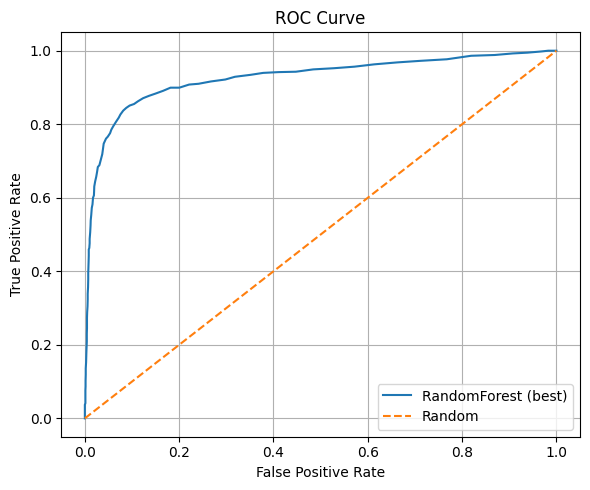

In [21]:
from sklearn.metrics import roc_curve

y_proba_best = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_best)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label="RandomForest (best)")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("artifacts/figures/roc_curve.png", dpi=200)
plt.show()


<Figure size 500x400 with 0 Axes>

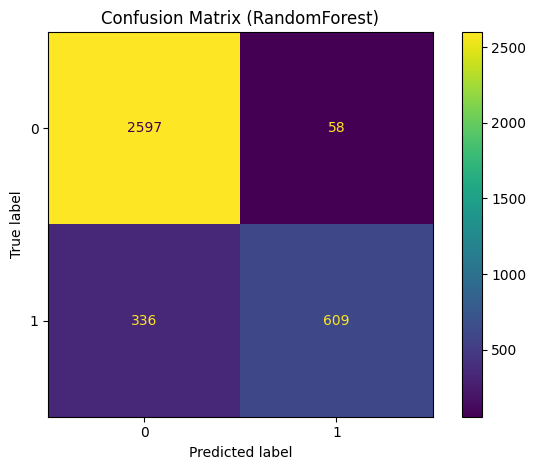

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best)
plt.title("Confusion Matrix (RandomForest)")
plt.tight_layout()
plt.savefig("artifacts/figures/confusion_matrix.png", dpi=200)
plt.show()


In [23]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring="roc_auc"
)

importance_df = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": perm.importances_mean
}).sort_values("importance_mean", ascending=False)

importance_df.head(15)


,feature,importance_mean
15,f16,0.048588
0,f01,0.018879
18,f19,0.017081
11,f12,0.014032
6,f07,0.010737
22,f23,0.010024
7,f08,0.009552
1,f02,0.009519
29,f30,0.009452
17,f18,0.009256


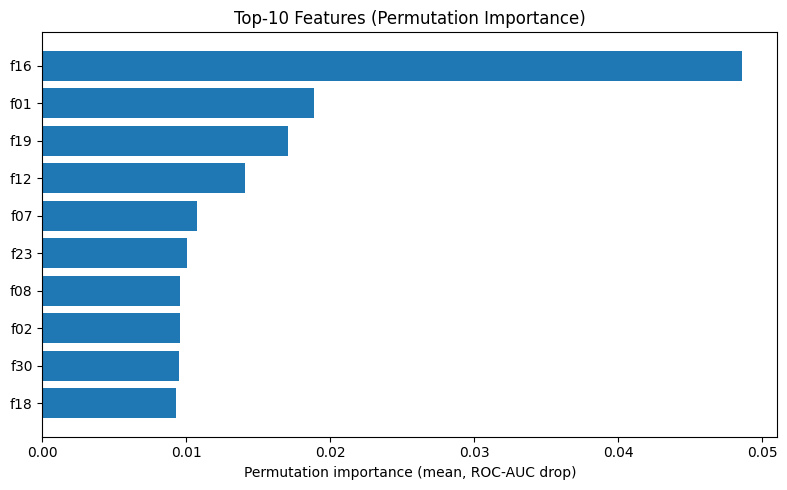

In [24]:
top_n = 10
plt.figure(figsize=(8, 5))
plt.barh(
    importance_df.head(top_n)["feature"][::-1],
    importance_df.head(top_n)["importance_mean"][::-1],
)
plt.xlabel("Permutation importance (mean, ROC-AUC drop)")
plt.title(f"Top-{top_n} Features (Permutation Importance)")
plt.tight_layout()
plt.savefig("artifacts/figures/permutation_importance.png", dpi=200)
plt.show()


По permutation importance видно, какие признаки сильнее всего влияют на качество предсказания.
Это помогает интерпретировать модель и понять, какие сигналы в данных наиболее важны.
